In [244]:
# coding: utf-8
# pylint: disable = invalid-name, C0111
import numpy as np
import pandas as pd
import lightgbm as lgb

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'  # fix error on MAC_OS

import numpy as np

from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_squared_error

import sklearn

from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import ShuffleSplit


import json

In [152]:
#### LOAD DATA 
print('Loading data...')
# load or create your dataset
df_train = pd.read_csv('../regression/regression.train', header=None, sep='\t')
df_test = pd.read_csv('../regression/regression.test', header=None, sep='\t')

y_train = df_train[0]
y_test = df_test[0]
X_train = df_train.drop(0, axis=1)
X_test = df_test.drop(0, axis=1)

print("Done load data")

Loading data...
Done load data


# BASIC USE 


In [166]:
print('Starting training...')
# train 

params = {
   'boosting_type':'gbdt', 
   'class_weight':None, 'colsample_bytree':1.0,
   'importance_type':'gain', 'learning_rate':0.1, 'max_depth':10,
   'min_child_samples':20, 'min_child_weight':0.001, 'min_split_gain':0.0,
   'n_estimators':200, 'n_jobs':2, 'num_leaves':32, 'objective': 'mean_squared_error',
   'random_state':None, 'reg_alpha':0.0, 'reg_lambda':0.0, 'silent':False,
   'subsample':1.0, 'subsample_for_bin':200000, 'subsample_freq':0
}

lgb_model = lgb.LGBMRegressor(**params)
print("gbm = {}\n--------".format(gbm))



# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle_func(y_true, y_pred):
    return 'RMSLE_NAME', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


record_store = dict()
lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric = rmsle_func, \
              early_stopping_rounds=5, verbose = 10, callbacks = [lgb.record_evaluation(record_store)])

print('Starting predicting...')
# predict
y_pred = lgb_model.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Starting training...
gbm = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='gain', learning_rate=0.1, max_depth=10,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=200, n_jobs=2, num_leaves=32,
       objective='regression_l2', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=False, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)
--------
Training until validation scores don't improve for 5 rounds.
[10]	training's l2: 0.189854	training's RMSLE_NAME: 0.308373	valid_1's l2: 0.195852	valid_1's RMSLE_NAME: 0.310088
[20]	training's l2: 0.166656	training's RMSLE_NAME: 0.288926	valid_1's l2: 0.18119	valid_1's RMSLE_NAME: 0.297588
[30]	training's l2: 0.151799	training's RMSLE_NAME: 0.275926	valid_1's l2: 0.174135	valid_1's RMSLE_NAME: 0.291133
Early stopping, best iteration is:
[34]	training's l2: 0.146961	training's RMSLE_NAME: 0.271603	valid_1's l2: 0.173624	valid

## Plot metric during training

In [167]:
pd.DataFrame(record_store)

,training,valid_1
RMSLE_NAME,"[0.3438312429913439, 0.3378780233904609, 0.332...","[0.3413526395461168, 0.33536859371159383, 0.33..."
l2,"[0.23854862758873377, 0.229717844884507, 0.222...","[0.237514285089172, 0.22882862025011821, 0.222..."


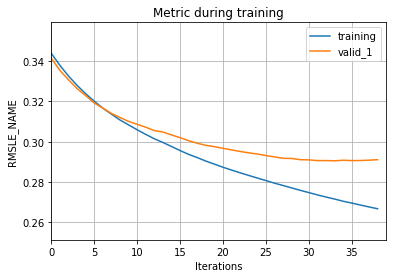

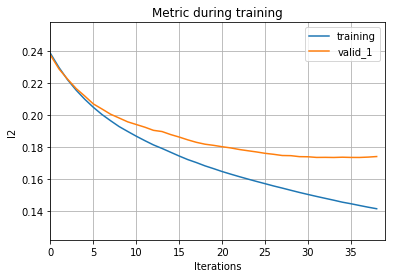

In [170]:
lgb.plot_metric(record_store, metric = 'RMSLE_NAME')
lgb.plot_metric(record_store, metric = 'l2')

## Plot individual tree

In [242]:
tree_i = 11
print('Plotting {}th tree with graphviz...'.format(tree_i))
graph = lgb.create_tree_digraph(lgb_model, tree_index= tree_i - 1, name='Tree_'+ str(tree_i)) # tree_index default = 0
graph

### show in pdf
graph.render(view=True)    


Plotting 11th tree with graphviz...


'Tree_11.gv.pdf'

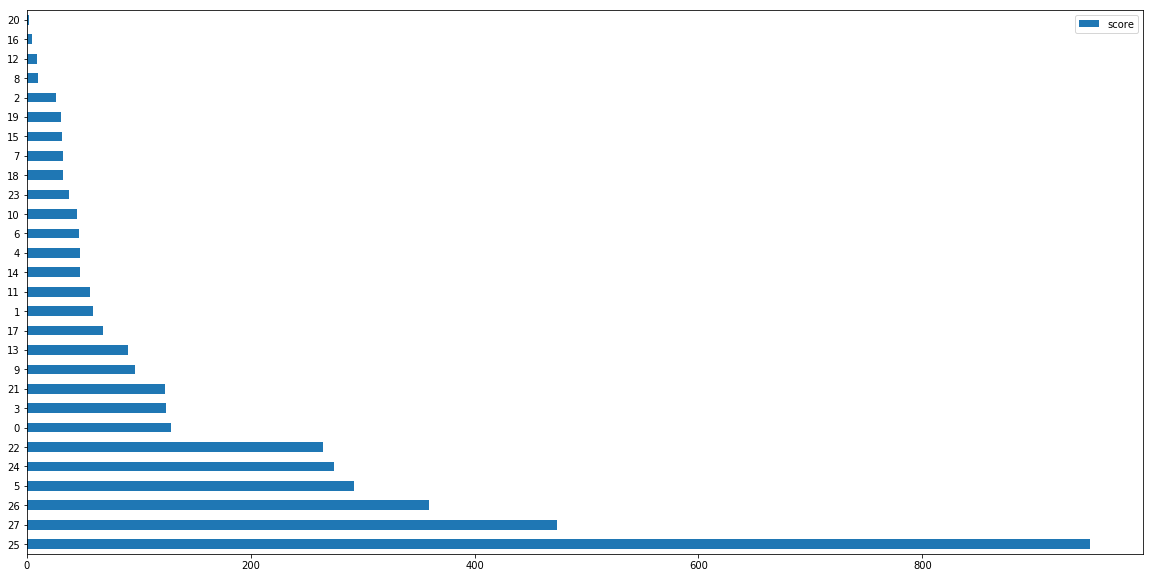

In [172]:
# plot feature importances
feature_names = list(range(X_train.shape[1]))
lgbm_feature_importance = pd.DataFrame(lgb_model.feature_importances_, index=feature_names, columns=["score"]).sort_values(by="score", ascending=False)
lgbm_feature_importance.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

In [245]:
#############
#### USE light gbm with python (not SKlearn wrapper)
# params_2 = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.2,
#     'bagging_freq': 1,
# }

# lgb_train = lgb.Dataset(X_train, y_train)
# gbm_2 = lgb.train(params=params_2,train_set=lgb_train,
#                 num_boost_round=30, verbose_eval = 10,
#                 valid_sets=lgb_train)



###### dump to txt and json files

# gbm_2.save_model('model.txt')

# model_json = gbm_2.dump_model()
# with open('model.json', 'w+') as f:
#     json.dump(model_json, f, indent=4)

[10]	training's binary_logloss: 0.622722
[20]	training's binary_logloss: 0.57958
[30]	training's binary_logloss: 0.551887


## Grid Search

In [246]:
# other scikit-learn modules
from sklearn.model_selection import StratifiedKFold

grid_record = dict()
random_seed = 2019
num_splits = 3

lgb_params = {
   'boosting_type':'gbdt', 'class_weight':None, 'colsample_bytree':1.0,
   'importance_type':'gain', 'learning_rate':0.1, 'max_depth':10,
   'min_child_samples':21, 'min_child_weight':0.001, 'min_split_gain':0.0,
   'n_estimators':200, 'n_jobs':2, 'num_leaves':32, 'objective':None,
   'random_state': random_seed, 'reg_alpha':0.0, 'reg_lambda':0.0, 'silent':False,
   'subsample':1.0, 'subsample_for_bin':200000, 'subsample_freq':0
}

param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100]
}

estimator = lgb.LGBMRegressor(**lgb_params)
print("estimator = {}\n--------".format(estimator))

cv = StratifiedKFold(n_splits = num_splits, random_state = random_seed)

estimator = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='gain', learning_rate=0.1, max_depth=10,
       min_child_samples=21, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=200, n_jobs=2, num_leaves=32, objective=None,
       random_state=2019, reg_alpha=0.0, reg_lambda=0.0, silent=False,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
--------


In [190]:
%%time

##### sorted(sklearn.metrics.SCORERS.keys())   # Scorers in grid
## method 1:
grid_model = GridSearchCV(estimator, param_grid, cv = cv, verbose=10, return_train_score = False,\
                              scoring = "neg_mean_squared_error", n_jobs=-1)


## method 2: use self-defined func
# mean_squared_error_func = make_scorer(mean_squared_error, greater_is_better=True)
# grid_model = GridSearchCV(estimator, param_grid, cv = cv, verbose=10, return_train_score = False,\
#                               scoring = mean_squared_error_func, n_jobs=-1)


grid_model.fit(X_train, y_train)

print('Best parameters found by grid search are:', grid_model.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    2.0s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    2.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.5s finished


Best parameters found by grid search are: {'learning_rate': 0.05, 'n_estimators': 100}
CPU times: user 849 ms, sys: 13.5 ms, total: 862 ms
Wall time: 2.97 s


In [186]:
grid_model.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [191]:
pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.960594,0.052295,0.027808,0.004337,0.05,100,"{'learning_rate': 0.05, 'n_estimators': 100}",-0.192454,-0.194744,-0.193215,-0.193471,0.000953,1
1,0.991924,0.537280,0.021832,0.002532,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",-0.197033,-0.199623,-0.198399,-0.198352,0.001058,2


### plot learning curve (training_valid errors by num_data_size)

<module 'matplotlib.pyplot' from '/anaconda3/envs/py36_env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

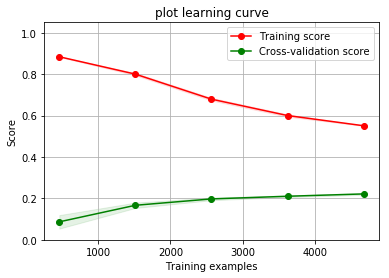

In [194]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs=n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


plot_learning_curve(grid_model.best_estimator_, "plot learning curve", X_train, y_train, ylim=(0, 1.05), cv = cv, n_jobs= -1)